#### Introducing Keras
Keras is a deep learning and neural networks API by François Chollet which is capable of running on top of Tensorflow (Google), Theano or CNTK (Microsoft).

To quote the wonderful book by François Chollet, Deep Learning with Python:

>Keras is a model-level library, providing high-level building blocks for developing deep-learning models. It doesn’t handle low-level operations such as tensor manipulation and differentiation. Instead, it relies on a specialized, well-optimized tensor library to do so, serving as the backend engine of Keras

It is a great way to start experimenting with neural networks without having to implement every layer and piece on your own. For example Tensorflow is a great machine learning library, but you have to implement a lot of boilerplate code to have a model running.

#### Keras supports two main types of models:
    
* the Sequential model API which you are going to see in use in this tutorial, and 
* the functional API which can do everything of the Sequential model but it can be also used for advanced models with complex network architectures.

The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the Dense layer which is your regular densely connected neural network layer with all the weights and biases that you are already familiar with.

#### load data 

https://archive-beta.ics.uci.edu/ml/datasets/331

In [1]:
import pandas as pd

filepath_dict = {'yelp':   'sentiment_data/yelp_labelled.txt',
                 'amazon': 'sentiment_data/amazon_cells_labelled.txt',
                 'imdb':   'sentiment_data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

In [2]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


#### split training and testing dataset.

In [3]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

#### use the CountVectorizer provided by the scikit-learn library to vectorize sentences

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

You can see that the resulting feature vectors have 750 samples which are the number of training samples we have after the train-test split. Each sample has 2505 dimensions which is the size of the vocabulary. 

### deep learning with keras 

In [5]:
from keras.models import Sequential
from keras import layers

In [6]:
input_dim = X_train.shape[1]  # Number of features

In [7]:
X_train.shape

(750, 1714)

In [8]:
input_dim

1714

In [9]:
# Dense layer == similar to perpectron hidden layer which has weights, bias 

model = Sequential()
# output = 10, input = size of vocabulary, activation function = relu 
model.add(layers.Dense(10, input_dim=input_dim, activation='relu')) 

# output = 1, activation function = sigmoid 
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                17150     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 17,161
Trainable params: 17,161
Non-trainable params: 0
_________________________________________________________________


You might notice that we have 17150 parameters for the first layer and another 11 in the second one. 

Where did those come from?

We have 1714 dimensions for each feature vector, and then we have 10 nodes. We need weights for each feature dimension and each node which accounts for 1714 * 10 = 17140 parameters, and then we have another 10 times an added bias for each node, which gets us the 17140+10 = 17150 parameters. 

In the final node, we have another 10 weights and one bias, which gets us to 11 parameters. 

That’s a total of 17150 + 11 = 17161  parameters for both layers.

In [11]:
history = model.fit(X_train, y_train, 
                    epochs=100,                   # 100 times of training 
                    verbose=False,
                    validation_data=(X_test, y_test), 
                    batch_size=10)               # for each training, how many dataset you want to use 


/projects/0ca79bd3-29e8-484c-b720-822c99947c31/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [12]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7920


You can already see that the model was overfitting since it reached 100% accuracy for the training set. But this was expected since the number of epochs was fairly large for this model. However, the accuracy of the testing set has already surpassed our previous logistic Regression with BOW model, which is a great step further in terms of our progress.

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

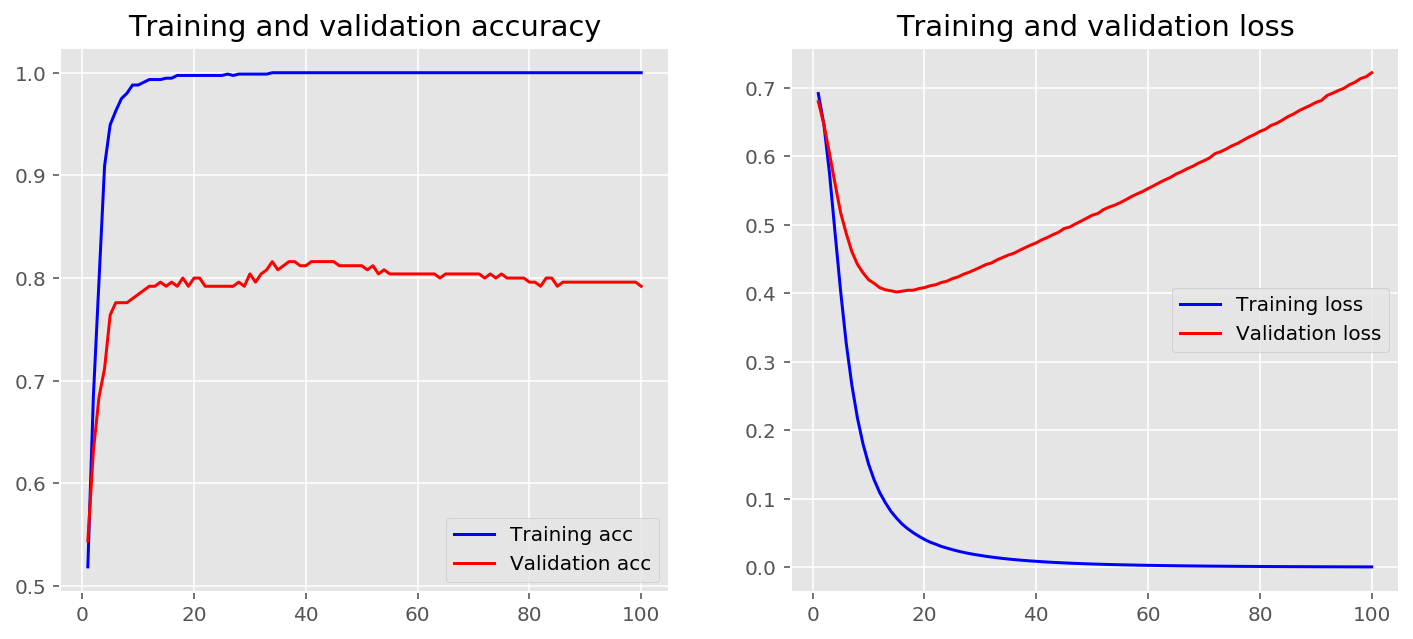

In [15]:
plot_history(history)

You can see that we have trained our model for too long since the training set reached 100% accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around 20-40 epochs in this training.